#**Submission Time Series**

Dataset yang saya gunakan yaitu data penjualan "harian" obat-obatan pada tahun 2014-2019 yang dapat dilihat pada https://www.kaggle.com/milanzdravkovic/pharma-sales-data.

Di dalam data ini terdapat beberapa istilah pada nama kolom, yaitu:
1. M01AB = Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
2. M01AE = Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
3. N02BA = Other analgesics and antipyretics, Salicylic acid and derivatives
4. N02BE/B = Other analgesics and antipyretics, Pyrazolones and Anilides
5. N05B = Psycholeptics drugs, Anxiolytic drugs
6. N05C = Psycholeptics drugs, Hypnotics and sedatives drugs
7. R03 = Drugs for obstructive airway diseases
8. R06 = Antihistamines for systemic use




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [24]:
df = pd.read_csv('/content/drive/My Drive/pharma_sales_daily.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         2106 non-null   object 
 1   M01AB         2106 non-null   float64
 2   M01AE         2106 non-null   float64
 3   N02BA         2106 non-null   float64
 4   N02BE         2106 non-null   float64
 5   N05B          2106 non-null   float64
 6   N05C          2106 non-null   float64
 7   R03           2106 non-null   float64
 8   R06           2106 non-null   float64
 9   Year          2106 non-null   int64  
 10  Month         2106 non-null   int64  
 11  Hour          2106 non-null   int64  
 12  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [5]:
#cek jumlah null value
df.isnull().sum()

datum           0
M01AB           0
M01AE           0
N02BA           0
N02BE           0
N05B            0
N05C            0
R03             0
R06             0
Year            0
Month           0
Hour            0
Weekday Name    0
dtype: int64

In [25]:
#Saya akan memprediksi penjualan N02BE(Other analgesics and antipyretics, Pyrazolones and Anilides)
#Oleh karena itu, saya hanya menggunakan 2 kolom (datum, N02BE)
dates = df['datum'].values
N02BE = df['N02BE'].values

In [26]:
#split data menjadi train, test
from sklearn.model_selection import train_test_split
date_train, date_test, N02BE_train, N02BE_test = train_test_split(dates, N02BE, test_size=0.2)
print(N02BE_train.shape)
print(N02BE_test.shape)

(1684,)
(422,)


In [27]:
#mengubah data supaya dapat diterima model 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds     = tf.data.Dataset.from_tensor_slices(series)
  ds     = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds     = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds     = ds.shuffle(shuffle_buffer)
  ds     = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

  
#mengubah data
windowed_train = windowed_dataset(N02BE_train, window_size=60, batch_size=100, shuffle_buffer=1000)
windowed_test = windowed_dataset(N02BE_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [28]:
#membuat model
model = Sequential([
                    LSTM(60, return_sequences=True),
                    LSTM(60),
                    Dense(30, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(1)
                    ])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

#fit data dengan validation_split 0.2
history = model.fit(windowed_train, validation_data=windowed_test, epochs=100)


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 2s 142ms/step - loss: 29.1756 - mae: 29.6708 - val_loss: 28.4817 - val_mae: 28.9791
Epoch 2/100
17/17 [==============================] - 2s 108ms/step - loss: 28.9266 - mae: 29.4242 - val_loss: 28.2703 - val_mae: 28.7691
Epoch 3/100
17/17 [==============================] - 2s 102ms/step - loss: 28.7370 - mae: 29.2359 - val_loss: 28.0909 - val_mae: 28.5904
Epoch 4/100
17/17 [==============================] - 2s 102ms/step - loss: 28.5529 - mae: 29.0524

In [31]:
#cek apakah nilai mae <10% skala data
max = df['N02BE'].max()
min = df['N02BE'].min()

#train mae
print(11.7946 < (max-min)/10)

#val mae
print(10.9888 < (max-min)/10)

True
True


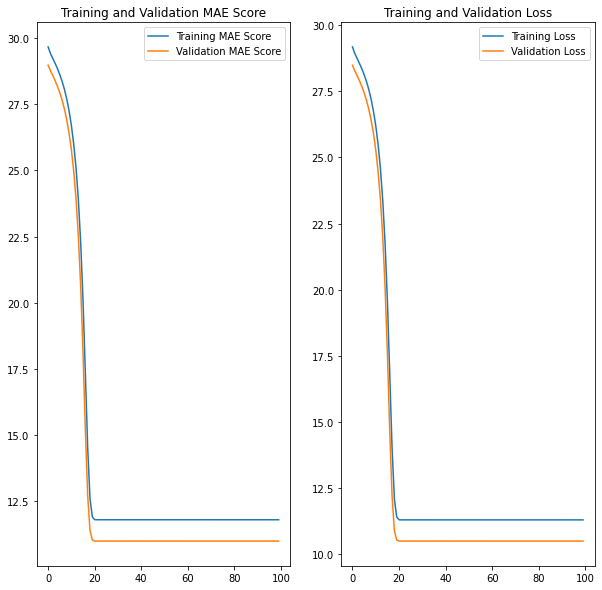

In [32]:
#plot akurasi 
import matplotlib.pyplot as plt

acc = history.history['mae']
val_acc = history.history['val_mae']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(100) 
plt.figure(figsize=(10, 10))

#visualisasi training and validation accurancy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MAE Score')
plt.plot(epochs_range, val_acc, label='Validation MAE Score')
plt.legend(loc='best')
plt.title('Training and Validation MAE Score')

#visualisasi training and validation loss 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()